# Stock Trading Analysis


## 1. Problem Definition
> Train an model to maximize cumulative profit after brokerage at the end of a day.

The model should predict whether the stock is going to go up or down and buy or sell/short the stock based on the prediction. This notebook will create a simple working model.

Hence:
> **Given the daily data of a stock, can a simple machine learning model make some cumulative profit at the end of a single day of trading?**

## 2. Load Data

### 2.1 Import required packages

In [1]:
import psycopg2
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates
from mpldatacursor import datacursor
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import pathlib
import os, time
import datetime
import json
import re
import pytz

pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', None)
timezone_str = 'Asia/Kolkata'
localtz = pytz.timezone(timezone_str)

# Import modules to make plots interactive.
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
!jupyter nbextension enable --py widgetsnbextension

# Import functions created for this project
from all_functions import connect, display_time, plot_stock_data, \
                          create_timestamp_obj, add_moving_average_to_df, add_slope_to_df, \
                          plot_data, plot_corr_mat, interactive_plot
from all_functions import create_df_from_sql, create_stocks_dfs

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Creating dataframe for NIFTY...
Connecting to the PostgreSQL database...
Database connection closed.
Creating dataframe for ONGC...
Connecting to the PostgreSQL database...
Database connection closed.
Creating dataframe for HDFC...
Connecting to the PostgreSQL database...
Database connection closed.
Creating dataframe for TCS...
Connecting to the PostgreSQL database...
Database connection closed.
Creating dataframe for MARUTI...
Connecting to the PostgreSQL database...
Database connection closed.
Creating dataframe for RELIANCE...
Connecting to the PostgreSQL database...
Database connection closed.


### 2.2 Unzip data

In [2]:
data_dir = 'data'
filename = 'stocks_data_2020_till_2020_09_03.sql.gz'

if (pathlib.Path(data_dir) / filename).exists():
    !gzip -d stocks_data_2020_till_2020_09_03.sql.gz
else:
    print('No files unzipped.')

No files unzipped.


### 2.3 Load data
The data related to all the stocks is in the `historic_data_pricehistory` table in the SQL database. This table consists of a column, `scrip_id` that refers to a particular stock. The corresponding stock names to a `scrip_id` can be found in the `historic_data_scrip` table.

In [3]:
stocks_id_df = create_df_from_sql(table_name='historic_data_scrip', columns=['id', 'name', 'exchange'], 
                         price_data=False, index_col=['id'])
stocks_id_df.head()

Connecting to the PostgreSQL database...
Database connection closed.


,name,exchange
id,,
1,GLENMARK,NSE
2,INDUSINDBK,NSE
3,TECHM,NSE
4,KOTAKBANK,NSE
5,RELIANCE,NSE


In [4]:
# Number of stocks in the dataset
stocks_id_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 1 to 66
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      66 non-null     object
 1   exchange  66 non-null     object
dtypes: object(2)
memory usage: 1.5+ KB


Loading in the data for Nifty 50 with all the columns available in the database.

In [5]:
nifty_df = create_df_from_sql(columns=["*"], index_col=['timestamp'])
nifty_df.head()

Connecting to the PostgreSQL database...
Database connection closed.


,id,deleted,identifier,created_at,updated_at,extra,open_price,high_price,low_price,close_price,volume,created_by_id,scrip_id,updated_by_id
timestamp,,,,,,,,,,,,,,
2020-06-18 09:15:00+05:30,615862,None,None,2020-08-16 23:37:14.651777+00:00,2020-08-16 23:37:14.651803+00:00,None,9863.25,9879.40,9850.25,9877.85,0,None,36,None
2020-06-18 09:16:00+05:30,615863,None,None,2020-08-16 23:37:14.651880+00:00,2020-08-16 23:37:14.651890+00:00,None,9878.15,9895.40,9877.20,9885.85,0,None,36,None
2020-06-18 09:17:00+05:30,615864,None,None,2020-08-16 23:37:14.651940+00:00,2020-08-16 23:37:14.651949+00:00,None,9885.70,9887.80,9874.95,9875.75,0,None,36,None
2020-06-18 09:18:00+05:30,615865,None,None,2020-08-16 23:37:14.651996+00:00,2020-08-16 23:37:14.652004+00:00,None,9877.00,9880.10,9865.25,9868.05,0,None,36,None
2020-06-18 09:19:00+05:30,615866,None,None,2020-08-16 23:37:14.652051+00:00,2020-08-16 23:37:14.652060+00:00,None,9869.40,9871.45,9863.90,9866.45,0,None,36,None


## 3. Explore data

From the above table, it is clear that there are multiple columns that have missing (`None`) values. Let's reduce our data and explore it to better understand some trends. First we will remove irrelevant data and then narrow down the data to be considered.

In [6]:
# Understand the type of data and the number of missing values.
nifty_df.info(), nifty_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36373 entries, 2020-06-18 09:15:00+05:30 to 2020-09-03 15:29:00+05:30
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   id             36373 non-null  int64              
 1   deleted        0 non-null      object             
 2   identifier     0 non-null      object             
 3   created_at     36373 non-null  datetime64[ns, UTC]
 4   updated_at     36373 non-null  datetime64[ns, UTC]
 5   extra          0 non-null      object             
 6   open_price     36373 non-null  float64            
 7   high_price     36373 non-null  float64            
 8   low_price      36373 non-null  float64            
 9   close_price    36373 non-null  float64            
 10  volume         36373 non-null  int64              
 11  created_by_id  0 non-null      object             
 12  scrip_id       36373 non-null  int64              
 13 

(None,
 id                   0
 deleted          36373
 identifier       36373
 created_at           0
 updated_at           0
 extra            36373
 open_price           0
 high_price           0
 low_price            0
 close_price          0
 volume               0
 created_by_id    36373
 scrip_id             0
 updated_by_id    36373
 dtype: int64)

### 3.1 Removing Irrelevant Data
As predicted `five` of the `14` columns have only `null` values. These columns are not going to help us find any trend in the data. Additionally, columns `id`, `created_at` and `updated_at` do not provide us with anything that could help us gage the movement of the time series.

In [7]:
nifty_df_updated = nifty_df.drop(['id', 'deleted', 'identifier', 'created_at', 'updated_at',
                                   'extra', 'created_by_id', 'updated_by_id'], axis=1)
nifty_df_updated.head()

,open_price,high_price,low_price,close_price,volume,scrip_id
timestamp,,,,,,
2020-06-18 09:15:00+05:30,9863.25,9879.40,9850.25,9877.85,0,36
2020-06-18 09:16:00+05:30,9878.15,9895.40,9877.20,9885.85,0,36
2020-06-18 09:17:00+05:30,9885.70,9887.80,9874.95,9875.75,0,36
2020-06-18 09:18:00+05:30,9877.00,9880.10,9865.25,9868.05,0,36
2020-06-18 09:19:00+05:30,9869.40,9871.45,9863.90,9866.45,0,36


### 3.2 Selecting stocks data to be considered
Due to the limiation of resources (like time), not all the `66` stocks/indices data present can be analysed in this notebook. Hence, I have chosen `five` stocks from **different industries** and `one` index to ensure a diverse set of data is used.

1. **Nifty 50**: scrip_id = 36;
    An index of 50 companies.
    This one should be the most volatile and hence should have large variations throughout the day.
2. **ONGC**: scrip_id = 11;
    A company in oil and energy industry.
3. **HDFC**: scrip_id = 12;
    A company in the banking industry.
4. **TCS**: scrip_id = 13;
    Consultancy firm in the Services industry (IT).
5. **MARUTI**: scrip_id = 31;
    A company in the automobile industry.
6. **RELIANCE**: scrip_id = 5;
    A conglomerate company.

In [8]:
# Creating a dictionary with their `scrip_id`s to easily access later.
stocks_dict = {
    'NIFTY': 36,
    'ONGC': 11,
    'HDFC': 12,
    'TCS': 13,
    'MARUTI': 31,
    'RELIANCE': 5}

Getting the data for the above stocks as dataframes and storing it in a dictionary.

In [9]:
stocks_main = create_stocks_dfs(stocks_dict)

start_time = create_timestamp_obj('2020-09-02-09-15-00')
end_time = create_timestamp_obj('2020-09-02-15-29-00')

one_day_stocks = {key: value[start_time:end_time]
                  for key, value in stocks_main.items()}

Creating dataframe for NIFTY...
Connecting to the PostgreSQL database...
Database connection closed.
Creating dataframe for ONGC...
Connecting to the PostgreSQL database...
Database connection closed.
Creating dataframe for HDFC...
Connecting to the PostgreSQL database...
Database connection closed.
Creating dataframe for TCS...
Connecting to the PostgreSQL database...
Database connection closed.
Creating dataframe for MARUTI...
Connecting to the PostgreSQL database...
Database connection closed.
Creating dataframe for RELIANCE...
Connecting to the PostgreSQL database...
Database connection closed.


### 3.3 Visualising the data

In [10]:
nifty_df_updated.describe()

,open_price,high_price,low_price,close_price,volume,scrip_id
count,36373.000000,36373.000000,36373.000000,36373.000000,36373.0,36373.0
mean,10354.698415,10357.969343,10351.417737,10354.698106,0.0,36.0
std,856.458349,856.016872,856.866881,856.455582,0.0,0.0
min,8810.400000,8814.000000,8807.500000,8811.250000,0.0,36.0
25%,9433.950000,9438.400000,9430.200000,9434.050000,0.0,36.0
50%,10376.250000,10379.350000,10372.950000,10376.450000,0.0,36.0
75%,11177.100000,11179.900000,11174.050000,11177.100000,0.0,36.0
max,11792.050000,11794.150000,11784.700000,11791.800000,0.0,36.0


The volume of column for the Nifty data is full of `0`s are it is an index and there is no volume associated with an index as it is a combination of stocks. Hence, while plotting `scrip_id` and `volume` columns are to be ignored.

#### Interactive plot
Below is an interactive plot (will need to use Jupyter Notebook/Lab to view and use it). We can change select the stocks whose data we would like to plot along with some other variables:
1. Stock or Index (out of the chosen 6)
2. Moving Average window
3. Slope window (fits using polyfit)
4. Boolean for plotting of a second degree slope or no.
5. Price to be considered: `close_price` or `open_price`

Different trends can be come as we play with these variables and see the changes in the graph.

In [11]:
columns = ['close_price',
           'open_price']

In [12]:
interactive(interactive_plot, stock_name=stocks_dict.keys(), avg_window=(5, 40, 5), slope_unit=(2, 40, 2), slope_price=True, slope_deg_2=True, slope_deg_3=True, column=columns)

interactive(children=(Dropdown(description='stock_name', options=('NIFTY', 'ONGC', 'HDFC', 'TCS', 'MARUTI', 'R…

#### Trends Observed
```# TODO: Talk about the trends observed in the above plots.```

## 4. Creating Transations Table
To create the table with the following heading, I have created a `Transactions` class to easily create and plot the data. The code for the class can is present in `transactions_table.py` in the current directory. We can easily change the conditions by editting the `.fit()` method in the class without going through the task of writing the code to create and plot the table.

### Transactions table: *Attempt 1*
> This is right after writing the code for the transactions table. *Septemeber 21, 2020*.

Very high losses observed with the conditions used.

In [13]:
from transactions_table import Transactions

In [22]:
t_default = Transactions(avg_window=25, slope_unit=20)
stock_name = 'RELIANCE'
t_default.fit(one_day_stocks[stock_name], stock_name, deg1_thres=0.1, deg2_thres=0)
t_default.transactions_df

,buy/sell,price,qtystock,profit,brokerage,cum_profit,pab,cum_pab
timestamp,,,,,,,,
2020-09-02 09:58:00+05:30,buy,2108.80,1,0.00,0.892022,0.00,-0.892022,-0.892022
2020-09-02 10:18:00+05:30,sell,2104.25,0,-4.55,1.353033,-4.55,-5.903033,-6.795055
2020-09-02 10:19:00+05:30,sell,2103.85,-1,0.00,1.352776,-4.55,-1.352776,-8.147831
2020-09-02 11:01:00+05:30,buy,2113.80,0,-9.95,0.894137,-14.50,-10.844137,-18.991968
2020-09-02 11:02:00+05:30,buy,2112.00,1,0.00,0.893376,-14.50,-0.893376,-19.885344
2020-09-02 12:13:00+05:30,sell,2135.40,0,23.40,1.373062,8.90,22.026938,2.141594
2020-09-02 12:14:00+05:30,sell,2134.00,-1,0.00,1.372162,8.90,-1.372162,0.769432
2020-09-02 14:23:00+05:30,buy,2129.40,0,4.60,0.900736,13.50,3.699264,4.468695
2020-09-02 14:24:00+05:30,buy,2131.45,1,0.00,0.901603,13.50,-0.901603,3.567092


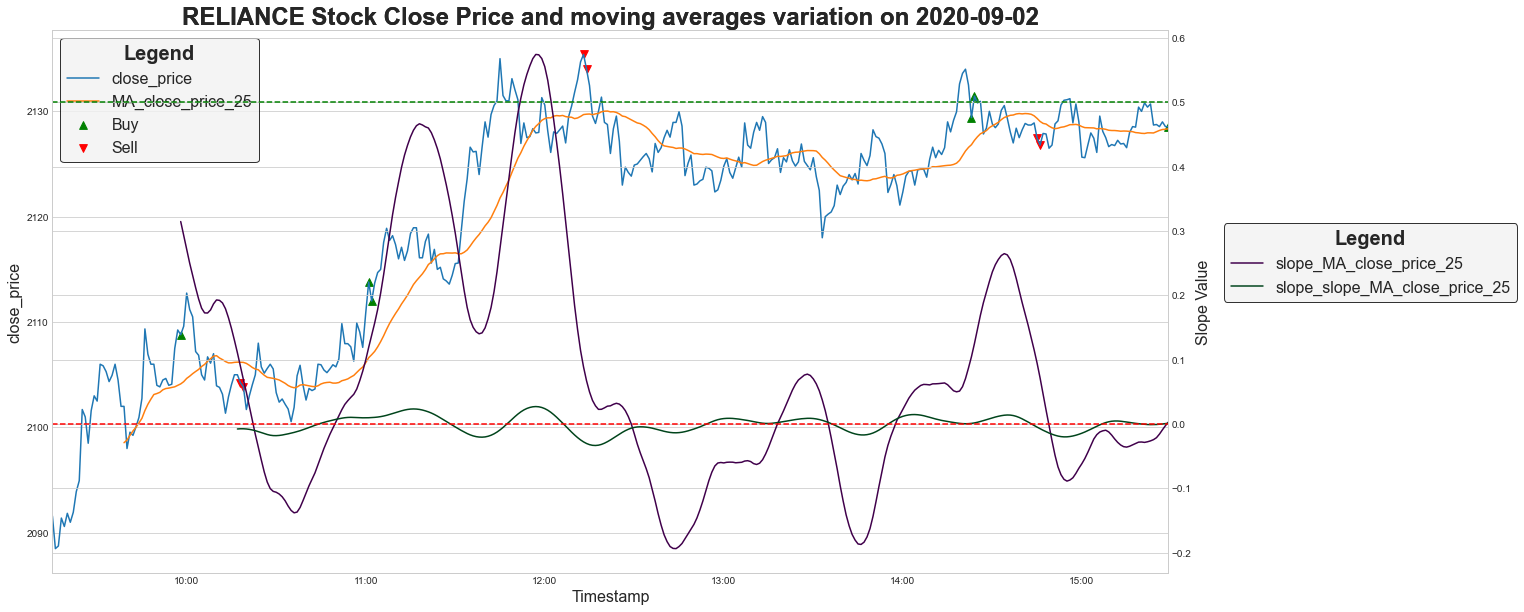

In [23]:
# plotting a graph
t_default.plot(figsize=(20, 10));

### 4.1 Improving Cumulative Profits
I have created a total of `six` methods that can be used to be take a decision on when to buy and sell the stock. We can now look at the performance of all these methods on the index `nifty`.

In [24]:
stock_name = 'NIFTY'

In [25]:
# Create instances and fit data
t_dict = {f't_{m}': Transactions(avg_window=25, slope_unit=25,method=m)
          for m in range(6)}

parameters = dict(dataframe = one_day_stocks[stock_name],
                  stock_name = stock_name,
                  deg1_thres = 0.4,
                  deg2_thres = 0)

for name, t in t_dict.items():
    t.fit(**parameters)

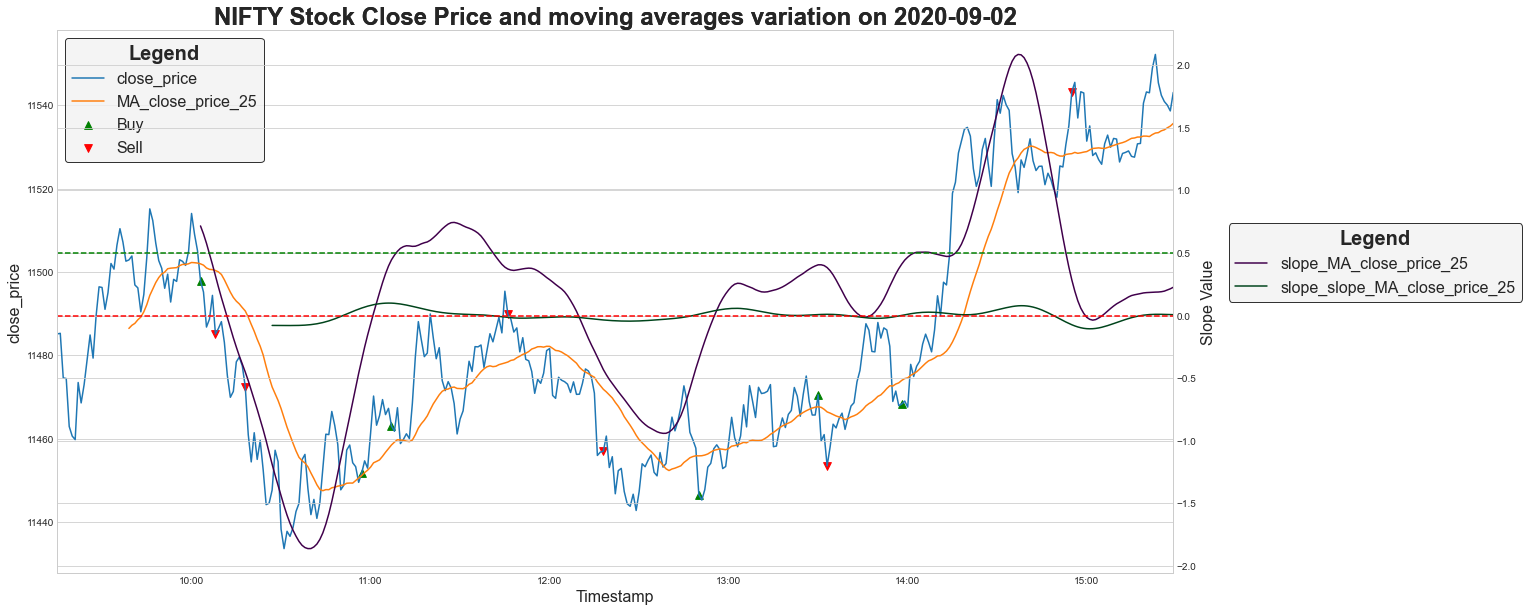

In [26]:
t_dict['t_1'].plot();

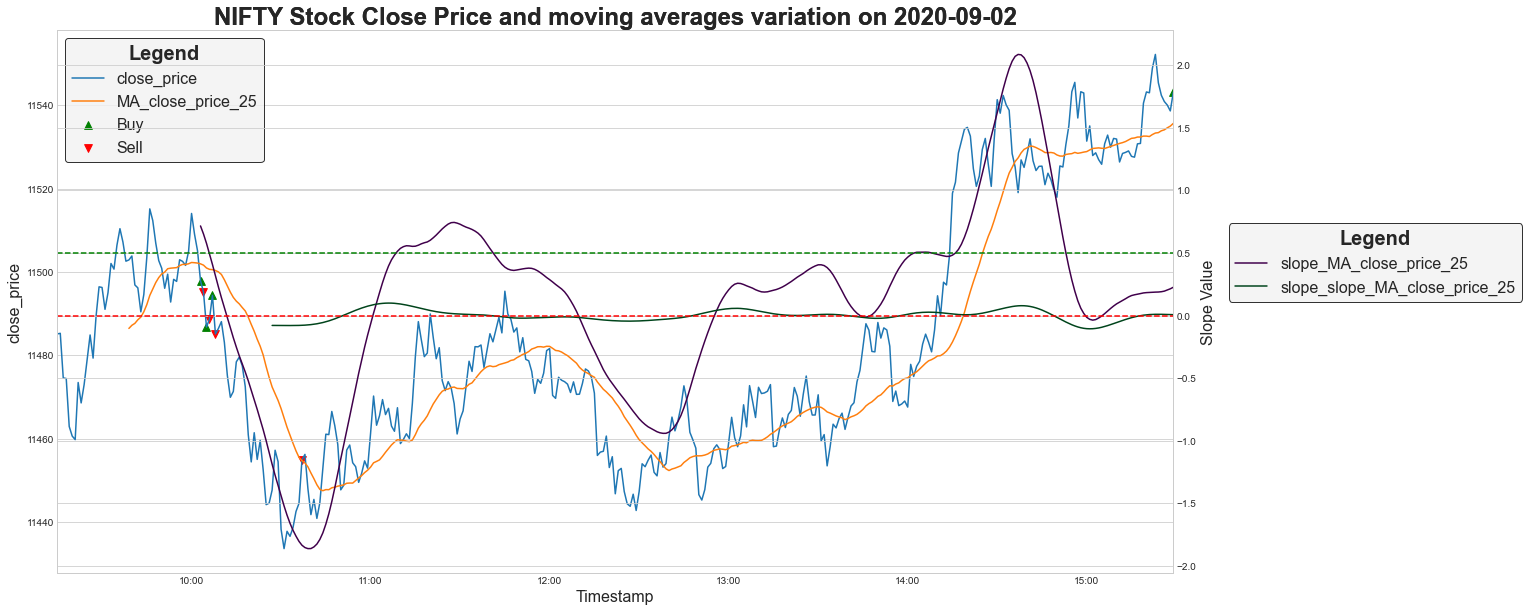

In [27]:
t_dict['t_2'].plot();

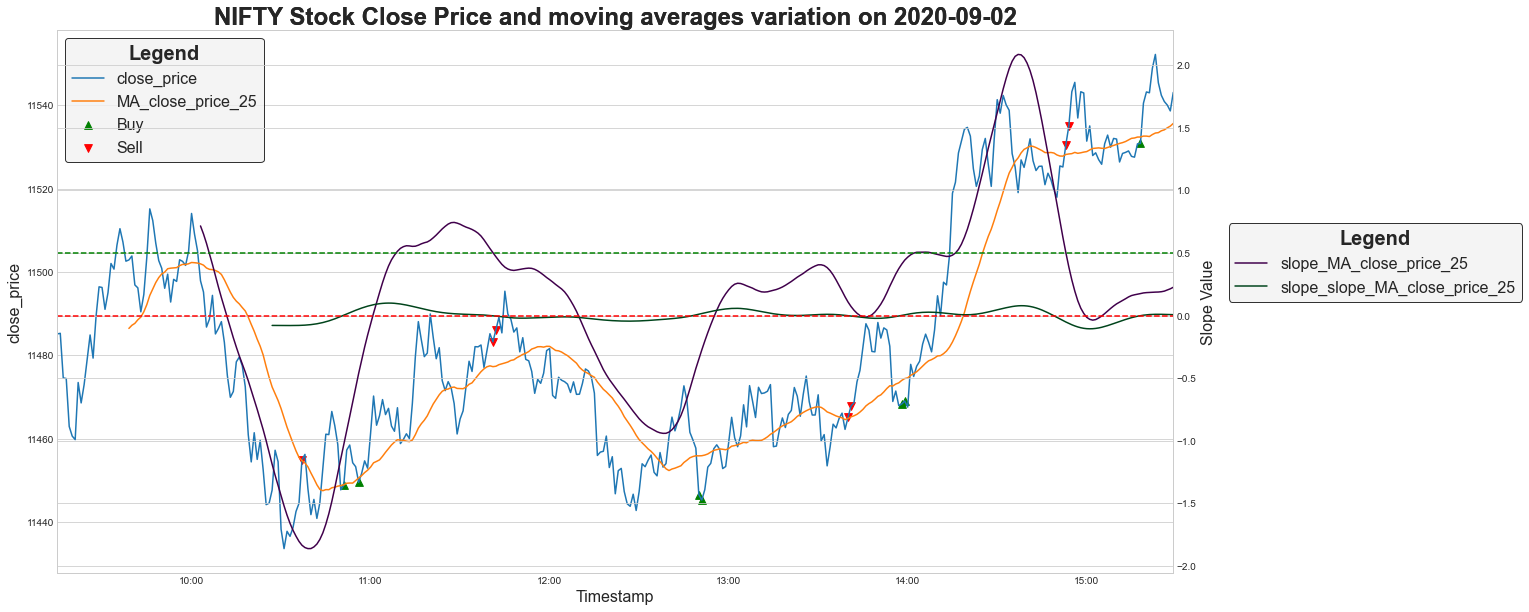

In [28]:
t_dict['t_3'].plot();

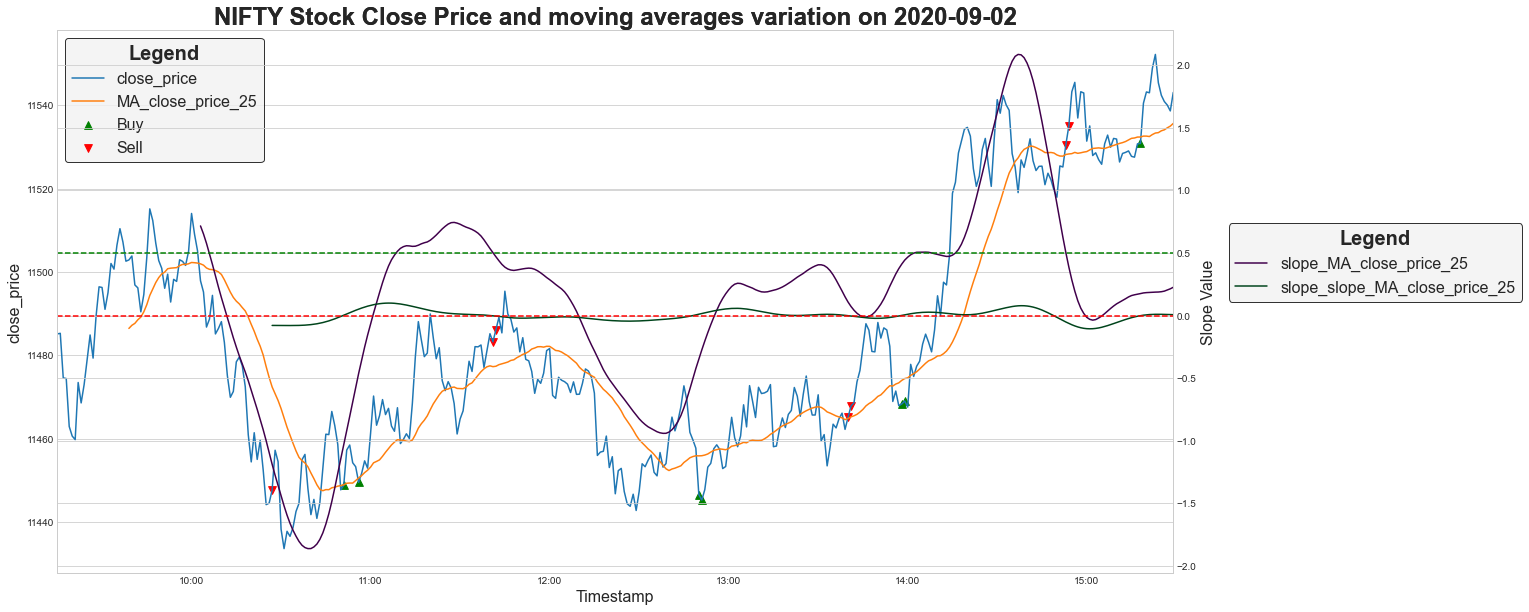

In [29]:
t_dict['t_4'].plot();

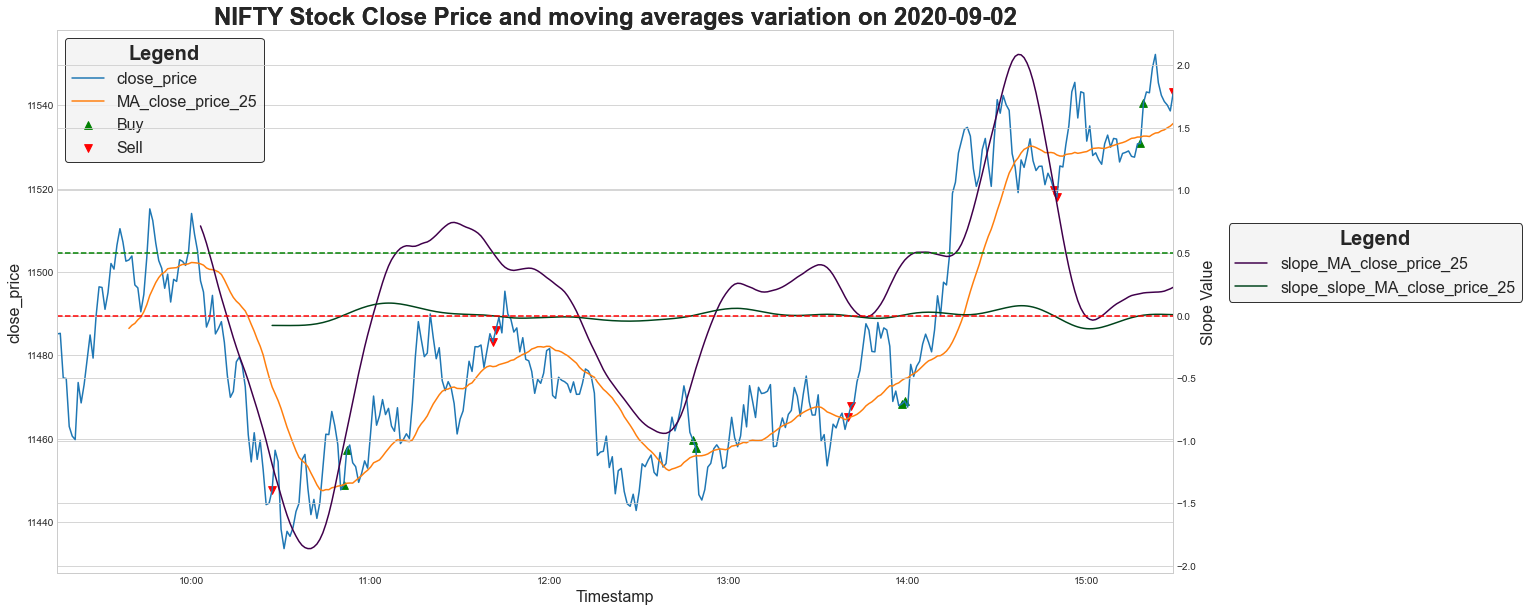

In [30]:
t_dict['t_5'].plot();

In [31]:
cum_pab_dict = {name: t.cum_pab for name, t in t_dict.items()}

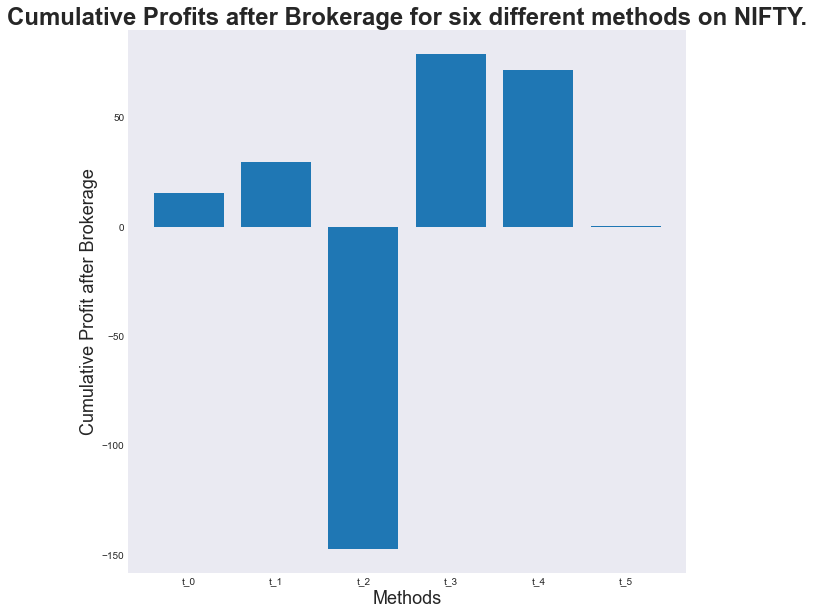

In [37]:
# Plot cumulative profit after brokerage
plt.style.use('seaborn-dark')

fig, ax = plt.subplots(figsize=(10,10))
ax.bar(x=list(cum_pab_dict.keys()), height=cum_pab_dict.values())
ax.set_title(f'Cumulative Profits after Brokerage for six different methods on {stock_name}.',
             fontdict={'size': 24, 'weight': 'bold'}, pad=2)
ax.set_xlabel('Methods', fontdict={'size': 18})
ax.set_ylabel('Cumulative Profit after Brokerage', fontdict={'size': 18});

The above process can be simplified into a small function that we can use everytime we want to understand which `method` performs well with a given `stock`.

In [38]:
# Creating a funciton to plot cum_pab for a given stock.
def plot_cum_pab(stock_name: str):
    
    cum_pab_dict = {}
    
    # Create instances and fit data
    t_dict = {f't_{m}': Transactions(avg_window=25, slope_unit=25,method=m)
              for m in range(6)}

    parameters = dict(dataframe = one_day_stocks[stock_name],
                      stock_name = stock_name,
                      deg1_thres = 0.4,
                      deg2_thres = 0)

    for name, t in t_dict.items():
        t.fit(**parameters)
        cum_pab_dict[name] = t.cum_pab
    
    # Plot cumulative profit after brokerage
    plt.style.use('seaborn-dark')

    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(x=list(cum_pab_dict.keys()), height=cum_pab_dict.values())
    ax.set_title(f'Cumulative Profits after Brokerage for six different methods on {stock_name}.',
                 fontdict={'size': 24, 'weight': 'bold'}, pad=0.5)
    ax.set_xlabel('Methods', fontdict={'size': 18})
    ax.set_ylabel('Cumulative Profit after Brokerage', fontdict={'size': 18});

In [39]:
# plotting an interactive plot to easily switch between stocks.
interactive(plot_cum_pab, stock_name=one_day_stocks.keys())

interactive(children=(Dropdown(description='stock_name', options=('NIFTY', 'ONGC', 'HDFC', 'TCS', 'MARUTI', 'R…